In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
#Load data
train = pd.read_csv('train.csv')
y = train['SalePrice']
train.drop(['Id','SalePrice'],axis = 1,inplace = True)

test = pd.read_csv('test.csv')

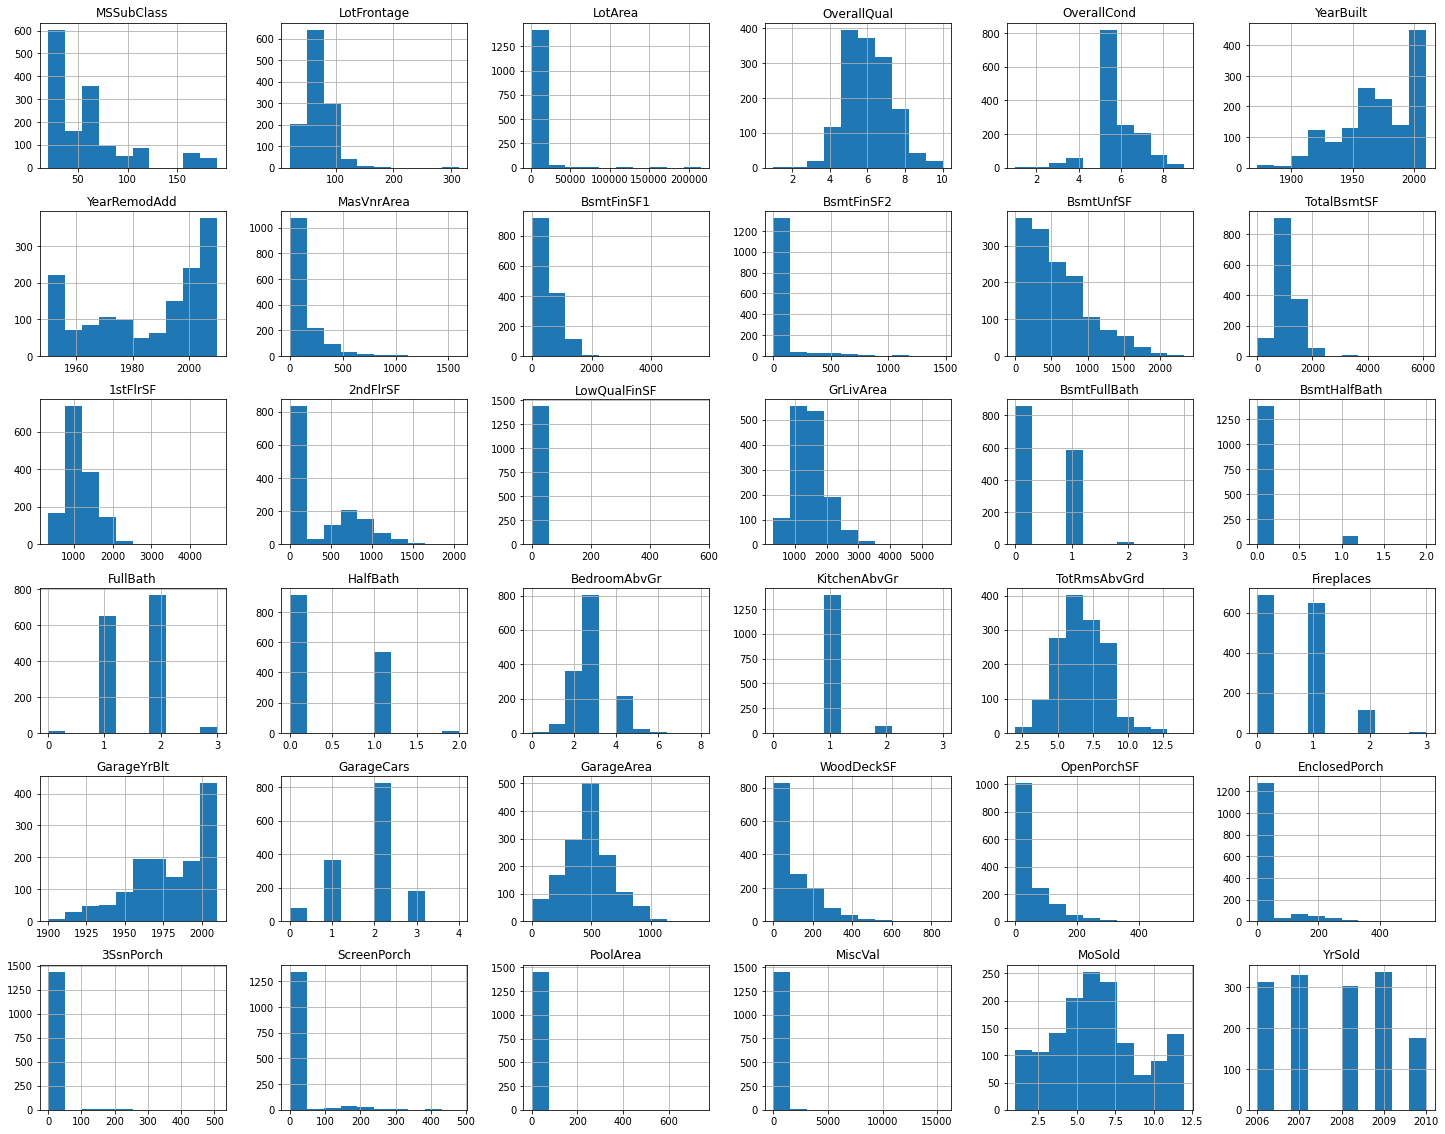

In [3]:
##Plot histogram
def numerical_plot(df):
    df.hist(figsize = (25,20))
    plt.show()
numerical_plot(train)

In [4]:
#PLOT CATEGORICAL DATA AS BARCHARTS
def categorical_plot(df,categorical):   
    for col in categorical:
        data = df[col].value_counts()
        for na in nan_categorical:
            if col == na:
                no_val=df[na].isna().value_counts().rename({True: 'Na value', False : '0'})                
                data = data.append(no_val)
                data = data.drop('0')
        data.plot.bar()
        plt.title(col)
        plt.show()
#categorical_plot(train,categorical)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


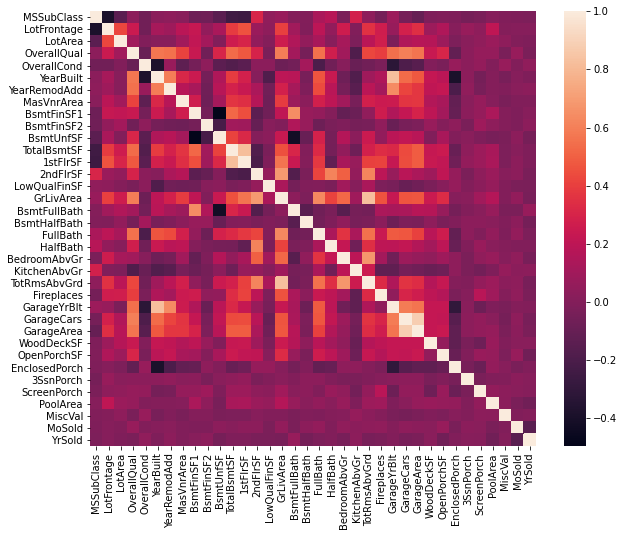

In [5]:
#CORRELATION MATRIX, HEAT MAP AND DATA DESCRIPTION (NUMERICAL)
corr_matrix = train.corr()
#corr_matrix['SalePrice'].sort_values()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
train.describe()

In [6]:
#Create a test set stratified related to Overall Qual feature since it is the most correlated variable
def strat_test_set(df):
    df['OverallQual_cat'] = pd.cut(df['OverallQual'],bins = [0,2,4,6,8,np.inf],labels = [1,2,3,4,5])
    from sklearn.model_selection import StratifiedShuffleSplit
    split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.2,random_state = 0)
    for train_index,test_index in split.split(train,train['OverallQual_cat']):
        strat_train_set = train.loc[train_index]
        strat_test_set = train.loc[test_index]
    for set_ in (strat_train_set, strat_test_set):
        set_.drop('OverallQual_cat',axis = 1, inplace = True)
    return strat_train_set, strat_test_set

In [7]:
##chech where are the nan values

def nan_cols(df):
    columns_nan = df.isna().sum()
    nan_val = columns_nan.where(columns_nan > 0).dropna()
    return list(nan_val.index)
nan_col = nan_cols(train)

#separate data into categorical and numerical and find where are nan values in each
def separate_data(df):
    categorical = [num for num in df.columns if df.dtypes[num] == 'object']
    numerical = [num for num in df.columns if df.dtypes[num] != 'object']
    
    nan_categorical = [cat for cat in nan_col if df.dtypes[cat] == 'object']
    nan_numerical = [na for na in nan_col if df.dtypes[na] != 'object']
    return categorical,numerical, nan_numerical,nan_categorical
categorical, numerical, nan_numerical,nan_categorical = separate_data(train)

In [8]:
##Replacing nan values in numerical features
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy = 'median')
#train_num = train.drop(categorical,axis = 1)
#imputer.fit(train_num)
#X = imputer.transform(train_num)
#train_num_transoformed = pd.DataFrame(X,columns = numerical)

In [9]:
def separate_categorical(df,categorical):##Separate categorical data to use in oneHotEncoder and OrdinalEncoder
    one_enc = []
    ordinal_enc = []
    sub = 'Gd'
    for col in categorical:
        if df[col].str.contains(sub).any() > 0:
            ordinal_enc.append(col)
        else:
            one_enc.append(col)
    remains = ['BsmtFinType2','BsmtFinType1','Utilities','GarageFinish']
    ordinal_enc.extend(remains)
    for i in remains:
        one_enc.remove(i)
    return one_enc, ordinal_enc
one_enc, ordinal_enc = separate_categorical(train,categorical)


def categorical_missing_None(df):
    df['Electrical'].fillna('SBrkr',inplace = True) #-----> Since SBrkr is the most common value and there is only one NAN
    df['MasVnrType'].replace({'None': 0},inplace =True)#----> Since None represents the absence of Masonry
#categorical_missing_None(train)



def categorical_nan_func(df,nan_categorical):
    for col in nan_categorical:
        df[col].fillna(0,inplace = True)
#categorical_nan_func(train,nan_categorical)   

In [10]:
###Pipeline to fill nan values
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
abs_categorical = categorical.copy()
abs_categorical.remove('Electrical')


num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy = 'median')),
    ('std_scaler',StandardScaler())
])

#cat_pipeline = Pipeline([
#    ('electrical',SimpleImputer(strategy = 'constant',fill_value = 'SBrkr')),
##    ('masvnrtype',SimpleImputer(strategy = 'constant',fill_value = 0)),
##    ('absence_values',SimpleImputer(strategy = 'constant',fill_value = 0)),
##    ('ordinal_enc',OrdinalEncoder()),
##    ('one_enc',OneHotEncoder())
    
#])


In [81]:
elec = ['Electrical']
train['MasVnrType'].replace({'None': 0},inplace =True)
full_pipeline = ColumnTransformer([
    ('num',num_pipeline,numerical),
    ('electrical',SimpleImputer(strategy = 'constant',fill_value = 'SBrkr'),elec),
    ('absence_values',SimpleImputer(strategy = 'constant',fill_value = 0),abs_categorical),
    #('ordinal_enc',OrdinalEncoder(),ordinal_enc),
    #('one_enc',OneHotEncoder(),one_enc)
])

In [82]:
data_prepared = full_pipeline.fit_transform(train)
data_prepared

array([[0.07337496353744775, -0.22087508895451458, -0.20714170777431132,
        ..., 0, 'WD', 'Normal'],
       [-0.8725627562389217, 0.4603197354510445, -0.09188637231949037,
        ..., 0, 'WD', 'Normal'],
       [0.07337496353744775, -0.08463612407340275, 0.07347997855047012,
        ..., 0, 'WD', 'Normal'],
       ...,
       [0.3098593934815401, -0.17546210066081064, -0.1478102655227861,
        ..., 'Shed', 'WD', 'Normal'],
       [-0.8725627562389217, -0.08463612407340275, -0.08016039471234772,
        ..., 0, 'WD', 'Normal'],
       [-0.8725627562389217, 0.23325479398252483, -0.05811154792968632,
        ..., 0, 'WD', 'Normal']], dtype=object)

In [83]:
housing = pd.DataFrame(data_prepared,columns = train.columns)


In [84]:
nan_cols(housing)

[]